atomic concentration       float64
magnetic susceptibility    float64
dtype: object
   atomic concentration  magnetic susceptibility
0          9.097390e+22             2.558210e-08
1          9.390180e+22             2.596050e-08
2          9.405450e+22             2.597560e-08
3          9.345920e+22             2.590490e-08
4          9.147590e+22             2.566230e-08


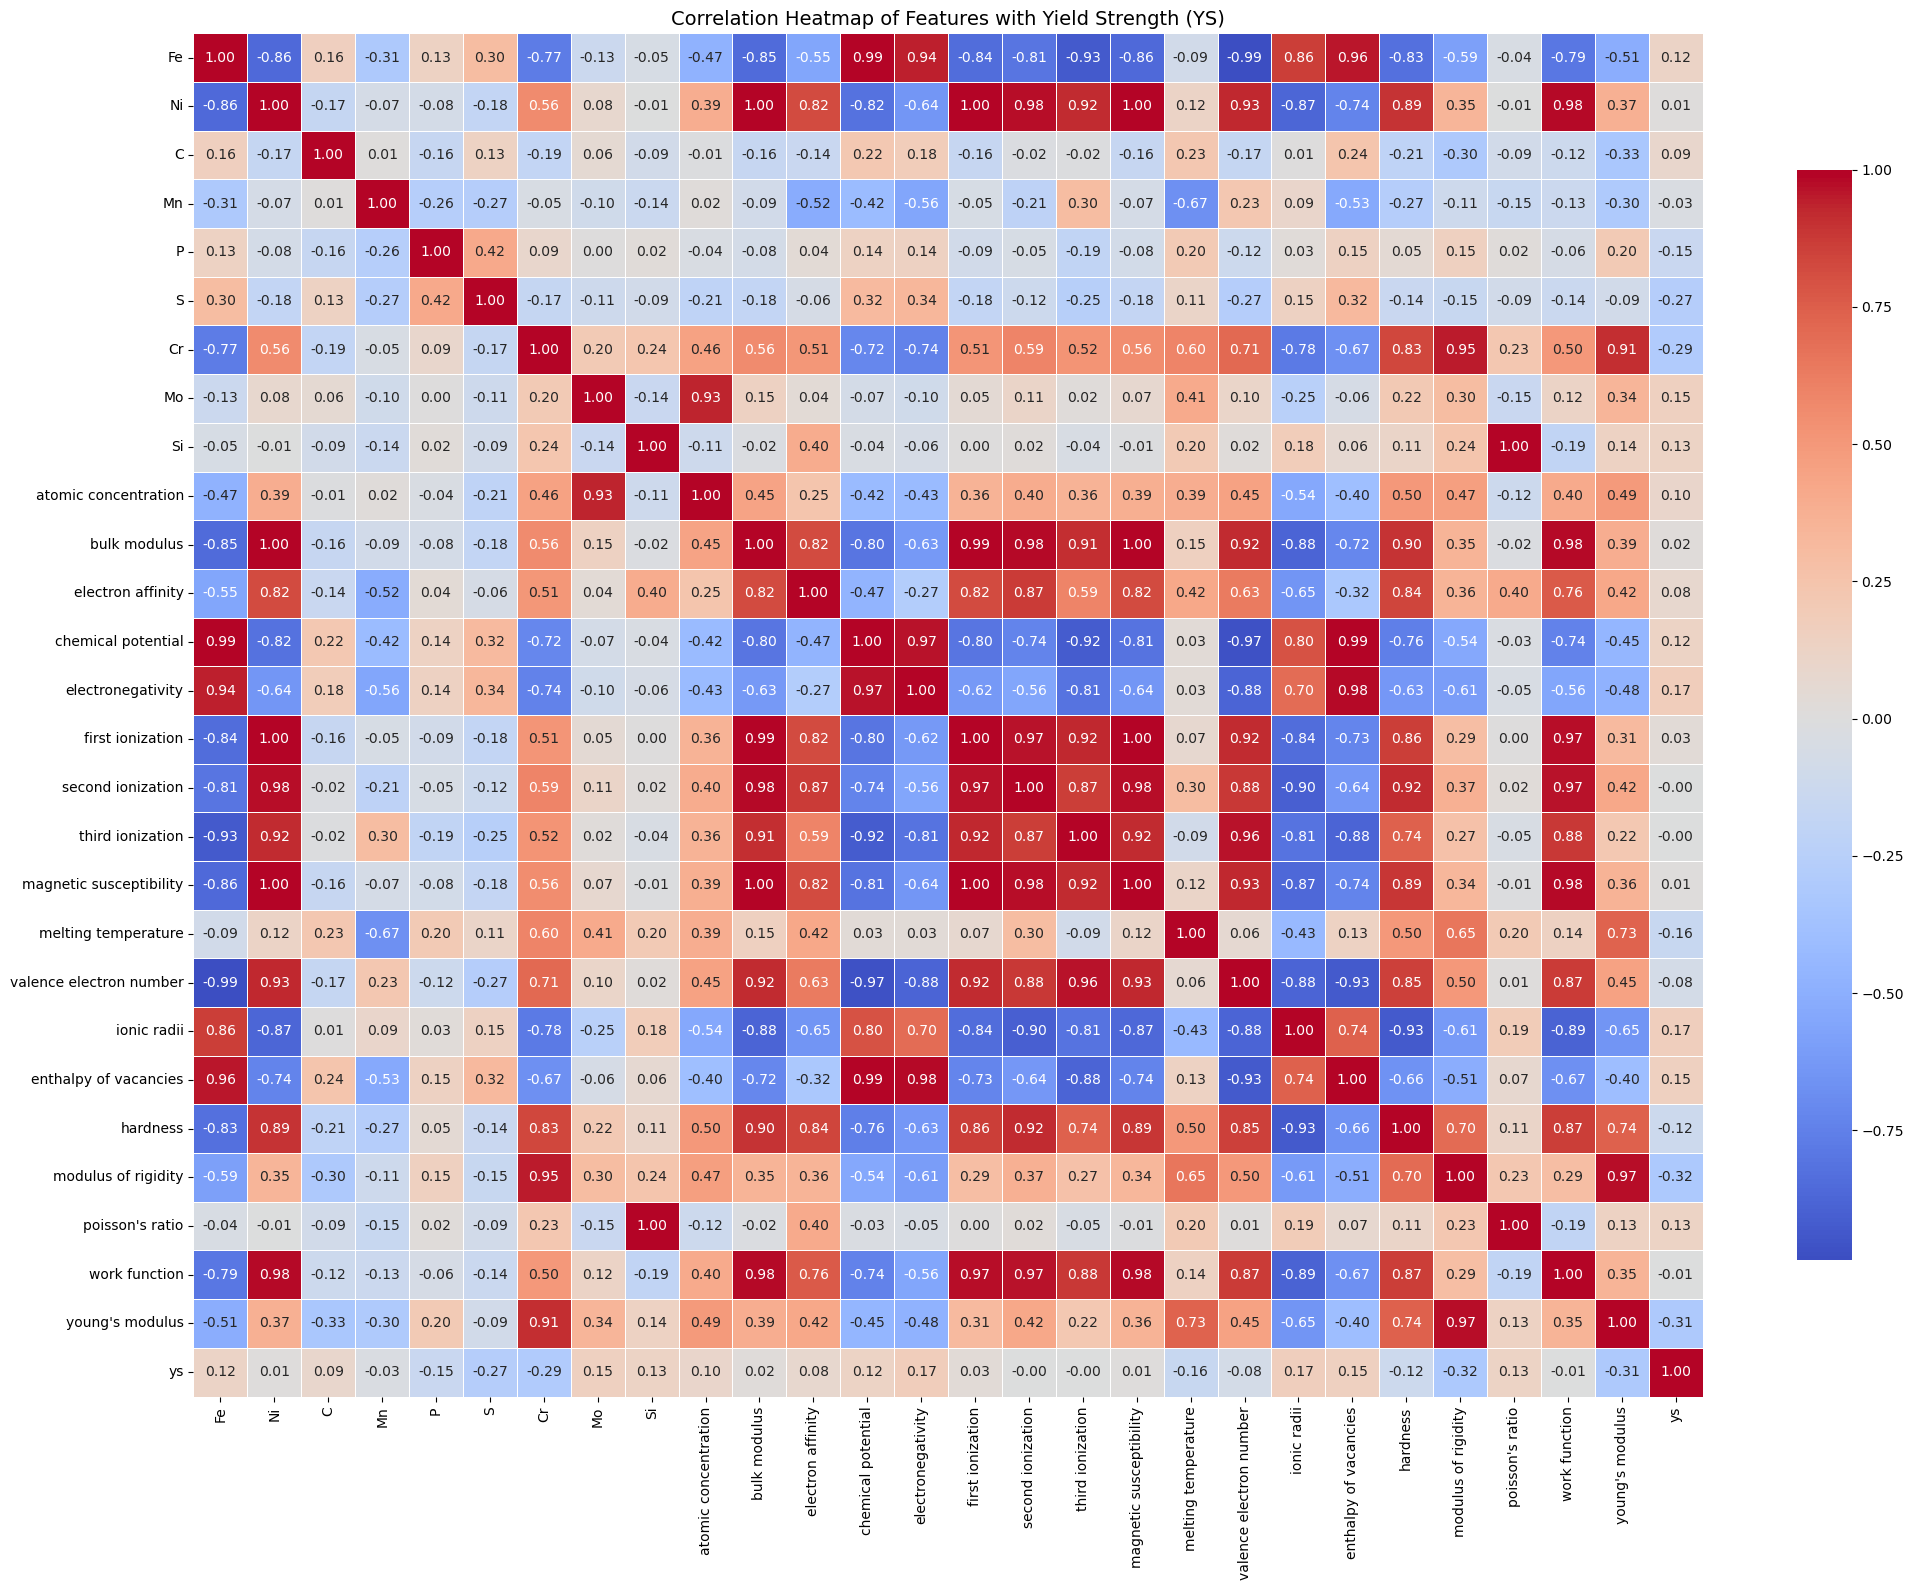

In [10]:
# ========== Import Libraries ==========
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
# ========== Load and Preprocess Data ==========
# Load your dataset
# ================== Load and Preprocess Data ==================
df = pd.read_excel(r"C:\Users\Tanvi Parihar\AppData\Local\Microsoft\Windows\INetCache\IE\CUHLPSQB\hydrogen_dataset[1].xlsx")

# Drop columns with all missing values
df = df.dropna(axis=1, how='all')

# Replace missing values in entire dataframe
df = df.fillna(0)

# Define features and target
X = df.drop(columns=['ys'])  # Features
y = df['ys']                 # Target

# (Optional) Handle any remaining NaNs (after defining X and y)
X = X.fillna(0)
y = y.fillna(0)

# Ensure target columns exist
target_columns = ['atomic concentration', 'magnetic susceptibility']

for col in target_columns:
    # 1. Convert to string
    df[col] = df[col].astype(str)
    
    # 2. Remove non-visible characters
    df[col] = df[col].str.replace('\u200b', '', regex=False)  # zero-width space
    df[col] = df[col].str.replace('\xa0', '', regex=False)    # non-breaking space
    df[col] = df[col].str.replace(' ', '')                    # normal spaces
    
    # 3. Keep only valid float characters (digits, ., e, E, -)
    df[col] = df[col].str.replace(r'[^\deE\.-]+', '', regex=True)
    
    # 4. Convert to float
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to float; invalid values → NaN
print(df[target_columns].dtypes)
print(df[target_columns].head())

# Replace missing values with 0 (assume element not present)
df = df.fillna(0)

# ========== Correlation Matrix ==========
corr_matrix = df.corr()

# ========== Plot Heatmap ==========
plt.figure(figsize=(21, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap of Features with Yield Strength (YS)", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP analysis

Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Train MSE: 8941.281577910808
Train R²: 0.9099969330214733
Test MSE: 43602.19360989399
Test R²: 0.5014221084701469


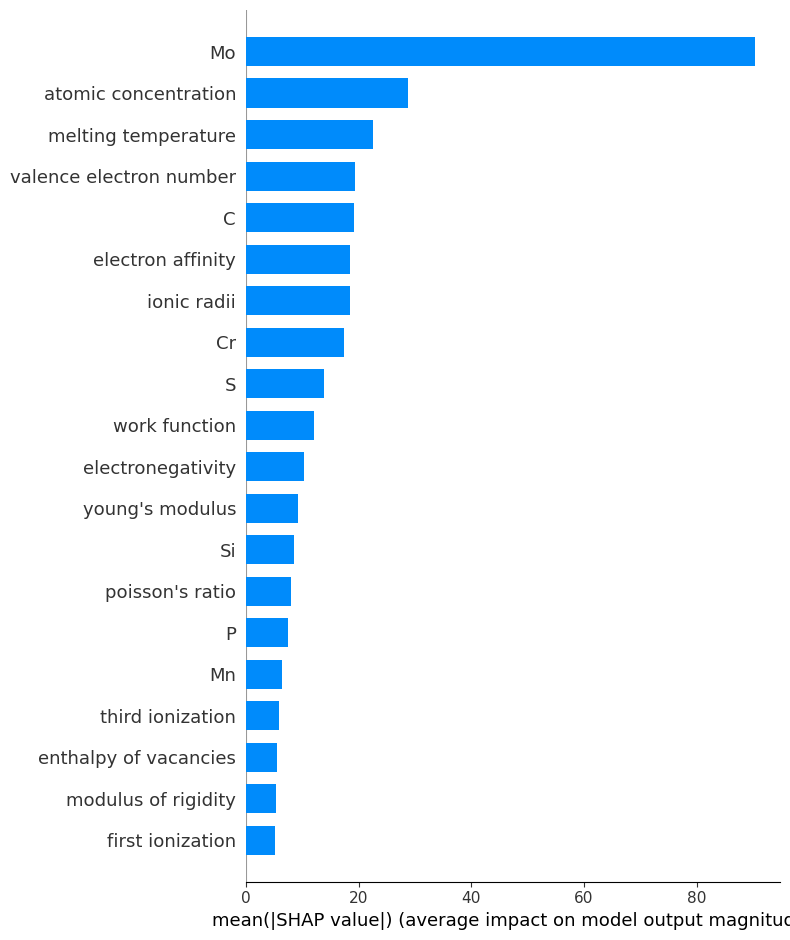

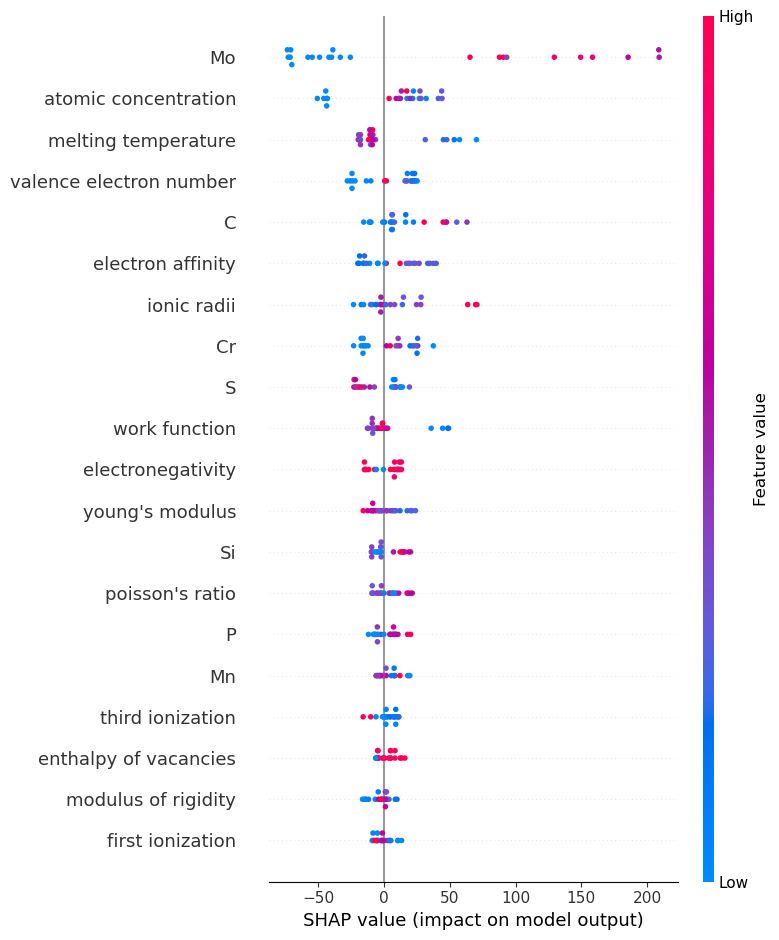

In [13]:
# ================== Import Libraries ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ================== Load and Preprocess Data ==================
df = pd.read_excel(r"C:\Users\Tanvi Parihar\AppData\Local\Microsoft\Windows\INetCache\IE\CUHLPSQB\hydrogen_dataset[1].xlsx")
# Drop columns with all missing values
df = df.dropna(axis=1, how='all')

# Replace missing values with 0 (assume element not present)
df = df.fillna(0)
# Handle any remaining NaNs in features BEFORE splitting
X = X.fillna(0)
y = y.fillna(0)  # (optional) if you suspect NaNs in y too
# Ensure target columns exist
target_columns = ['atomic concentration', 'magnetic susceptibility']

for col in target_columns:
    # 1. Convert to string
    df[col] = df[col].astype(str)
    
    # 2. Remove non-visible characters
    df[col] = df[col].str.replace('\u200b', '', regex=False)  # zero-width space
    df[col] = df[col].str.replace('\xa0', '', regex=False)    # non-breaking space
    df[col] = df[col].str.replace(' ', '')                    # normal spaces
    
    # 3. Keep only valid float characters (digits, ., e, E, -)
    df[col] = df[col].str.replace(r'[^\deE\.-]+', '', regex=True)
    
    # 4. Convert to float
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to float; invalid values → NaN

 # Define features and target
X = df.drop(columns=['ys'])  # Features
y = df['ys']                 # Target ys 
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ================== XGBoost with Hyperparameter Tuning ==================
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200,400],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.0, 0.1, 0.5, 1],   # L1 regularization (lasso)
    'reg_lambda': [1,5]    # L2 regularization (ridge)
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


# ================== Predictions ==================
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# ================== Evaluation ==================
print("Best Parameters:", grid_search.best_params_)
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
# ================== SHAP Explanation ==================

import shap
# Create explainer for tree-based models
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot (global explanation)
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar chart for feature importance
shap.summary_plot(shap_values, X_test)  # Beeswarm plot for distribution

# feature importance

Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Train MSE: 8941.281577910808
Train R²: 0.9099969330214733
Test MSE: 43602.19360989399
Test R²: 0.5014221084701469

 Feature Importances:
                    Feature  Importance
7                        Mo    0.165505
2                         C    0.099045
9      atomic concentration    0.067977
20              ionic radii    0.066274
6                        Cr    0.054467
11        electron affinity    0.054051
18      melting temperature    0.051581
19  valence electron number    0.049303
25            work function    0.041633
26          young's modulus    0.032840
5                         S    0.031831
4                         P    0.029176
14         first ionization    0.026634
13        electronegativity    0.025818
24          poisson's ratio    0.025312
16         third ionization    0.022274
0                        Fe    0.022160
3                        Mn    0.021776
10             bulk modul

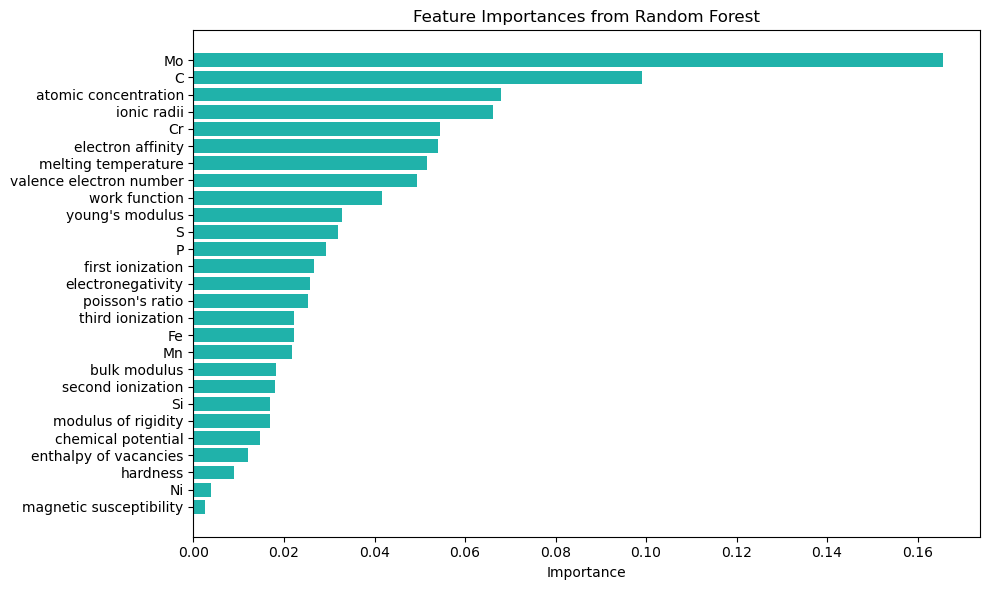

In [16]:
# ================== Import Libraries ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ================== Load and Preprocess Data ==================
df = pd.read_excel(r"C:\Users\Tanvi Parihar\AppData\Local\Microsoft\Windows\INetCache\IE\CUHLPSQB\hydrogen_dataset[1].xlsx")

# Drop columns with all missing values
df = df.dropna(axis=1, how='all')

# Replace missing values with 0 (assume element not present)
df = df.fillna(0)

# Clean specific target columns
target_columns = ['atomic concentration', 'magnetic susceptibility']
for col in target_columns:
    df[col] = df[col].astype(str)
    df[col] = df[col].str.replace('\u200b', '', regex=False)
    df[col] = df[col].str.replace('\xa0', '', regex=False)
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace(r'[^\deE\.-]+', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.fillna(0)  # Fill NaNs after type conversion

# Define features and target
X = df.drop(columns=['ys'])  # Features
y = df['ys']                 # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ================== XGBoost with Hyperparameter Tuning ==================
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200,400],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.0, 0.1, 0.5, 1],   # L1 regularization (lasso)
    'reg_lambda': [1,5]    # L2 regularization (ridge)
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


# ================== Predictions ==================
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# ================== Evaluation ==================
print("Best Parameters:", grid_search.best_params_)
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

# ================== Feature Importance from Random Forest ==================
importances = best_model.feature_importances_
feature_names = X.columns  # automatically match feature names

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances:")
print(feat_importance_df)

# ================== Optional: Bar Plot ==================
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='lightseagreen')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# recursive feature selection

Dataset loaded successfully. Shape: (76, 16)
After preprocessing. Shape: (76, 16)
Features shape: (76, 15)
Target shape: (76,)
Target statistics:
count      76.000000
mean      628.744737
std       312.677921
min       155.000000
25%       396.250000
50%       610.450000
75%       761.250000
max      1550.000000
Name: ys, dtype: float64

Top 10 Selected Features by RFE:
['Fe', 'Ni', 'C', 'Cr', 'Mo', 'Si', 'atomic concentration', 'electron affinity', 'ionic radii', 'enthalpy of vacancies']

Feature Importance of Selected Features:
atomic concentration     0.513005
Cr                       0.141682
Si                       0.102472
C                        0.081477
Fe                       0.065620
enthalpy of vacancies    0.042991
ionic radii              0.020545
Ni                       0.012799
electron affinity        0.010317
Mo                       0.009092
dtype: float32


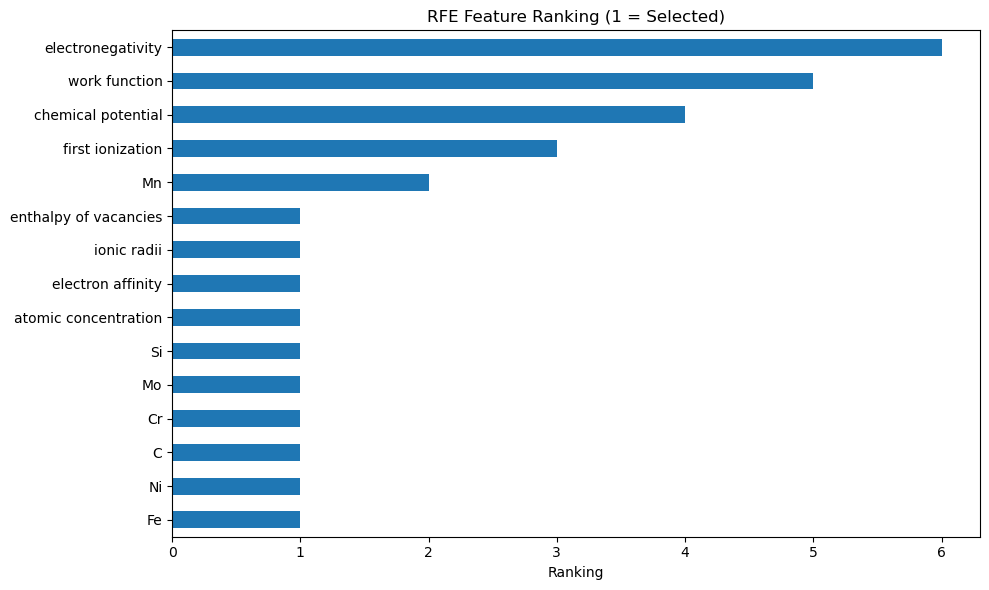

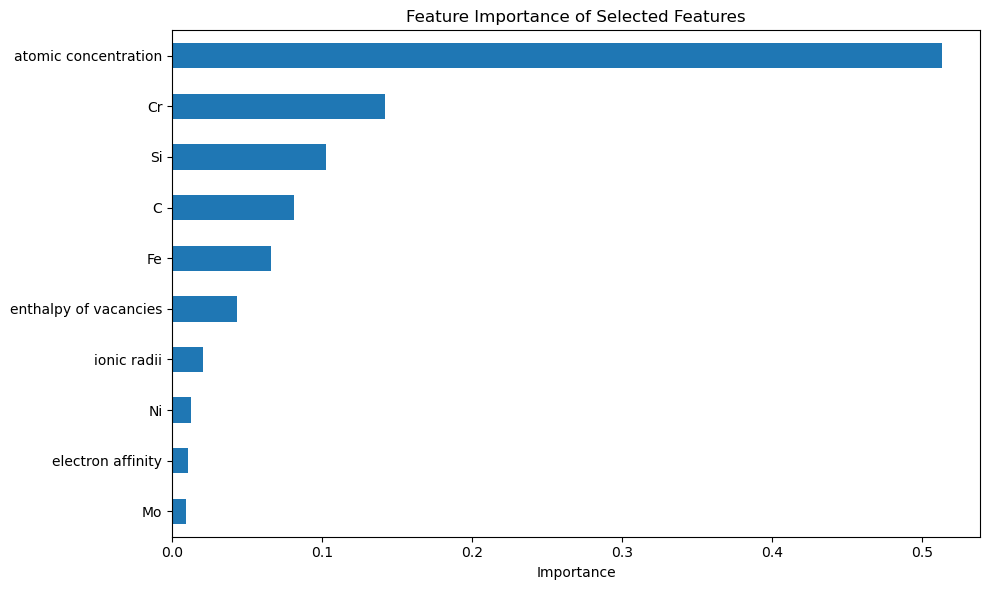


Analysis completed successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import os

# ========== Load Dataset ==========
file_path = r"C:\Users\Tanvi Parihar\OneDrive\Documents\hydrogen embrittlement dataset .xlsx"

# Check if file exists
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    exit()

try:
    df = pd.read_excel(file_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

# ========== Data Preprocessing ==========
# Check for the target column
if 'ys' not in df.columns:
    print("Error: Target column 'ys' not found in dataset")
    print("Available columns:", df.columns.tolist())
    exit()

# Remove completely empty columns and fill NaN values
df = df.dropna(axis=1, how='all').fillna(0)
print(f"After preprocessing. Shape: {df.shape}")

# ========== Prepare Features and Target ==========
X = df.drop(columns=['ys'])
y = df['ys']

# Basic data validation
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target statistics:\n{y.describe()}")

# Check if we have enough features for RFE
n_features_to_select = min(10, X.shape[1])  # Don't select more features than available
if n_features_to_select < 10:
    print(f"Warning: Only {X.shape[1]} features available. Selecting {n_features_to_select} features.")

# ========== Apply RFE with XGBoost ==========
model = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_estimators=100,  # Add some basic parameters
    max_depth=6,
    learning_rate=0.1
)

rfe = RFE(model, n_features_to_select=n_features_to_select)
rfe.fit(X, y)

# ========== Get Selected Features ==========
selected_features = X.columns[rfe.support_]
print(f"\nTop {n_features_to_select} Selected Features by RFE:")
print(selected_features.tolist())

# ========== Feature Importance from Selected Features ==========
# Fit the model with selected features to get feature importance
X_selected = X[selected_features]
model.fit(X_selected, y)

feature_importance = pd.Series(model.feature_importances_, index=selected_features)
print(f"\nFeature Importance of Selected Features:")
print(feature_importance.sort_values(ascending=False))

# ========== Visualization ==========
# Plot 1: RFE Feature Ranking
plt.figure(figsize=(12, 8))
ranking = pd.Series(rfe.ranking_, index=X.columns)
ranking.sort_values().plot(kind='barh', figsize=(10, max(6, len(X.columns)*0.3)), 
                          title="RFE Feature Ranking (1 = Selected)")
plt.xlabel("Ranking")
plt.tight_layout()
plt.show()

# Plot 2: Feature Importance of Selected Features
if len(selected_features) > 0:
    plt.figure(figsize=(10, 6))
    feature_importance.sort_values().plot(kind='barh', 
                                        title="Feature Importance of Selected Features")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

print("\nAnalysis completed successfully!")